# Generating Ion-Ion Couplings

## Code setup

In [1]:
import numpy as np
from numpy import sin, cos, exp, sqrt, angle
import scipy.integrate as integrate
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
import importlib
import sys, os
from pathlib import Path
sys.path.append('tools/')
import IonChainTools as ict
import MSFidelityEstimation as msfe
importlib.reload(msfe)
from MSFidelityEstimation import *

## Intro

A particular mode $m$ of a string of $N$ ions is described a vector $\eta^m$ where $\eta^m_i$ is the participation of ion $i$ in mode $m$.

In an MS-type operation, the displacement of a particular motional in phase space generates a state-dependent phase (in the $X$ basis of the qubits). Assuming that the motional mode is returned to its original state at the end of the operation, the unitary acting on the qubits is $U=J_m^2$ where $J=\sum_i \eta^m_i X_i$. (Note that more generally we could have some pauli operator that is a superposition of $X_i$ and $Y_i$, but we'll just use $X_i$ for simplicity.)

If we excite multiple motional modes and they each generate a phase $\chi_m$, then the unitary becomes $U = \sum_m \chi_m J_m^2$. Importantly, we do *not* have $U=\sum_m (\chi_m J_m)^2$. While the vectors $\eta^m$ fully span the space of real $N$-vectors, the matrices $\eta^m(\eta^m)^\text{T}$ do not span the full space of real $N\times N$ matrices. This means that even if we could get arbitrary contributions from each motional mode, we could not generate arbitrary couplings between each ion. This is simply a matter of algebra: with $N$ values of $\chi_m$, we cannot control all $(N^2-N)/2$ couplings between ions.

This prohibits doing an arbitrary two-qubit gate with a global drive, but obviosly does not prohibit doing so with individual addressing. If we only address the qubits that we want to operate on, then all couplings that involve other ions are never used.

## Trying to generate couplings using global drives

We know that we cannot get arbitrary couplings between ions just from a linear combination of the couplings generated by each mode, but we can still try to get some useful couplings.

### Nearest-Neighbor $XX$

We are trying to generate the unitary $U=\sum_{i}^{N-1} X_i X_{i+1}$.

The coupling can be visually presented as the following:

<Axes: >

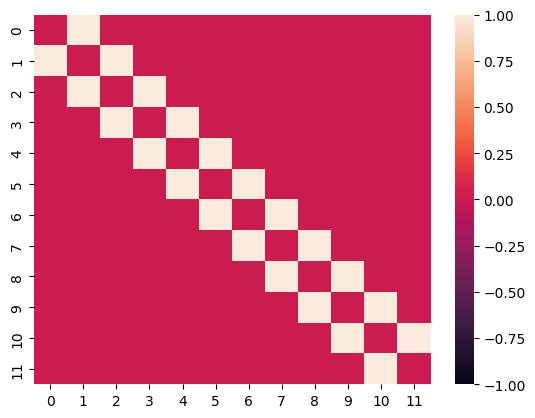

In [3]:
N = 12
A = np.zeros((N,N))
for i in range(N-1):
    A[i][i+1] = 1
    A[i+1][i] = 1
sb.heatmap(A, vmin=-1, vmax=1)

The couplings generated by each motional mode look like the following:

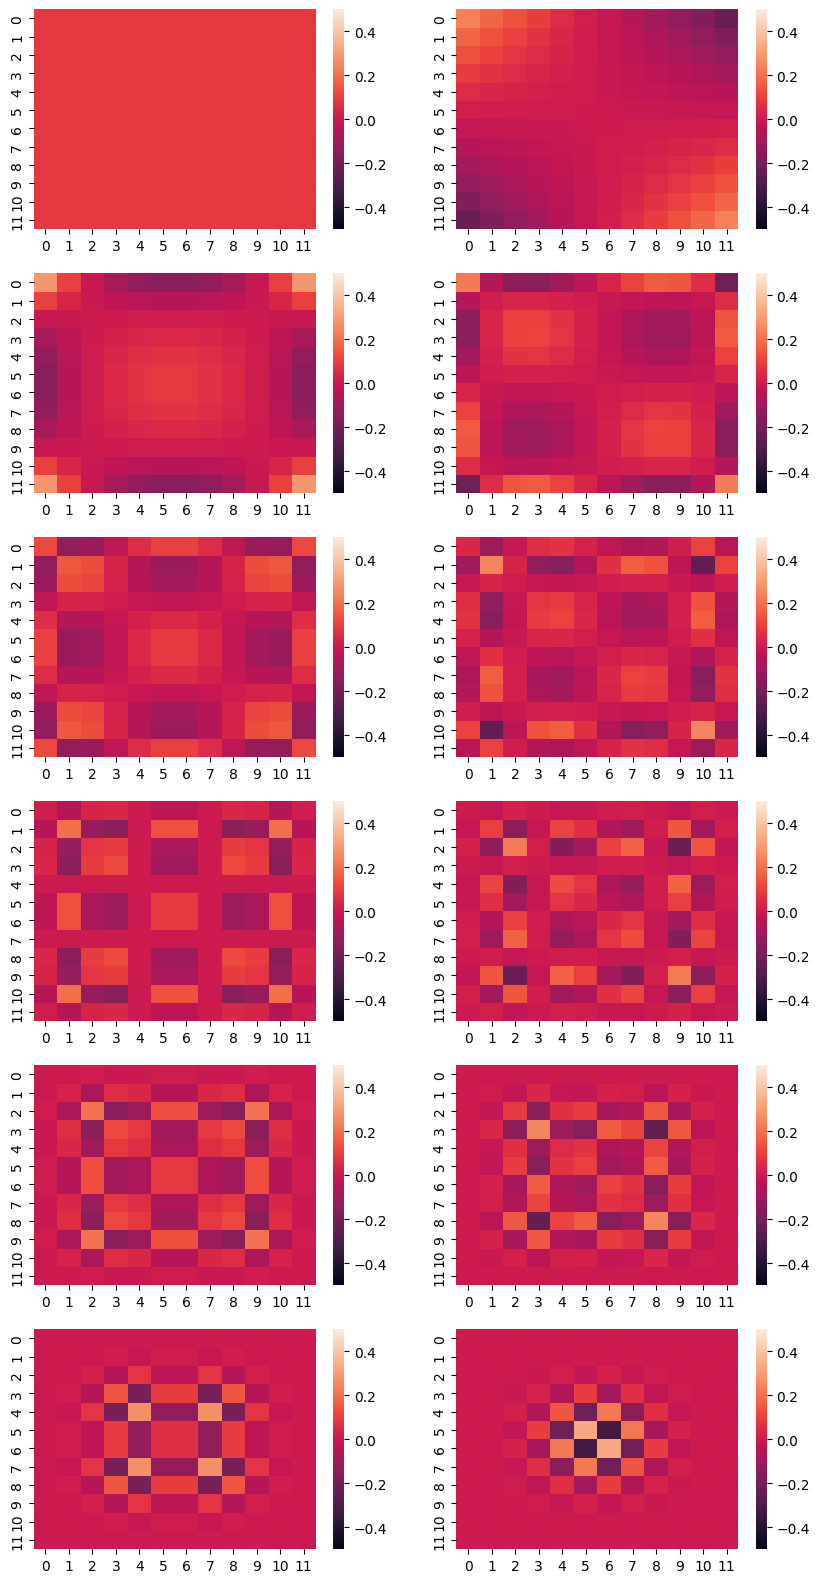

In [4]:
modes = ict.calcAxialModes(N)
mvecs = [m[1] for m in modes]
fig, axs = plt.subplots(int(N/2), 2, figsize=(10,20))
axs_flat = [ax for axrow in axs for ax in axrow]
for ax, mvec in zip(axs_flat, mvecs):
    sb.heatmap(np.outer(mvec, mvec), ax=ax, vmin=-0.5, vmax=0.5)

We can try to combine the above couplings into a uniform nearest neighbor coupling by vectorizing the coupling matrices and projecting the nearest neighbor coupling vector onto the space spanned by the mode-generated coupling vectors.

In [5]:
def normalize(vec):
    return vec/np.linalg.norm(vec)

In [6]:
modes = ict.calcAxialModes(N)
mvecs = [mode[1] for mode in modes]
B = np.stack([normalize(np.outer(mvec,mvec).flatten()) for mvec in mvecs]).T
A_vec = A.flatten()

In [7]:
mode_contribs, residual, _, _ = np.linalg.lstsq(B, A_vec)

/tmp/ipykernel_1207308/214715069.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  mode_contribs, residual, _, _ = np.linalg.lstsq(B, A_vec)


In [8]:
A_vec_regenerated = np.sum([normalize(np.outer(mvec,mvec).flatten())*mode_contrib for mvec,mode_contrib in zip(mvecs, mode_contribs)], axis=0)
A_regenerated = np.reshape(A_vec_regenerated, (N,N))

<Axes: >

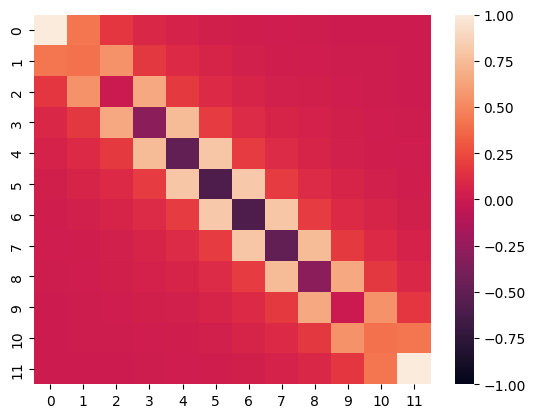

In [9]:
sb.heatmap(A_regenerated, vmin=-1, vmax=1)

This result is pretty bad. Maybe it's possible to just use the center of the string? I don't know how the Ozeri group got good results in "PHYSICAL REVIEW A 101, 032330 (2020) Theory of robust multiqubit nonadiabatic gates for trapped ions". They likewise simply do a least squares method.